## Natural gradient

#### Краткий синопсис

В этой части мы рассмотрим тему, которая находится на границе тем о матрице Фишера и KL-дивергенции. 

Натуральные градиенты это метод оптимизации в котором шаг оптимизации в градиентном спуске делается.

План семинара:

Нормальные градиенты:

  1. Ввести студентов в курс дела, показать 2D-нормальное распределение;
  2. Посчитать log-likelihood и его градиент;
  3. Показать, что KL-дивергенция никак не зависит от параметризации;
  4. Сделать градиентный спуск в трёх параметризациях и сравнить их(вспомнив азы оптимизации);
  5. Реализовать подсчёт матрицы Фишера;
  6. Переход к натуральным градиентам: сравнить скорость сходимости(в естественной параметризации должна быть такая же скорость сходимости);
  7. Рассказать о том что шаг по натуральному градиенту <=> argmin KL(p|q)
  8. Показать что для экспоненциального семейства матрица Фишера это вторая производная по параметрам от нормализационной константы(и сравнить численный подсчёт с этим).
  
Вассерштайн:
  1. Теор справка
  2. Реализовать подсчёт Вассерштайна в лоб(полный перебор ~n^2)
  3. Реализовать по-умному(сортировка, ~n log n)

### Maximum likelihood оптимизация

Очень часто в машинном обучении и статистике возникает задача когда есть данные $X$, некоторое параметрическое распределение $p(x | \theta)$ и желание найти параметры $\theta$. 

Самые лучшие параметры это те которые минимизируют функцию правдоподобия: $\mathcal{L}(X, \theta)$, во многих случаях это можно сделать аналитически(почти для всех известных нам именных распределений).

В случае если нет возможности посчитать аналитически MLE-оценки приходится обращаться к итеративным методам оптимизации. Один из самых популярных способов это градиентный спуск, который, формально решает следующую задачу:

$$d \theta = \arg \max \mathcal{L}(X|\theta + d \theta), s.t. ||d\theta|| < \epsilon$$

И результатом решения этой задачи является:

$$d\theta = \frac{\nabla_\theta \mathcal{L}}{||\nabla_\theta \mathcal{L}||} \epsilon$$

Оптимально ли это? 

Нет. Мы ограничиваем наш шаг $||d\theta||$ сферой радиусом $\epsilon$ в евклидовом пространстве, но это неразумно.

К примеру, сравним два распределения с $\mu_1 = -2, \mu_2 = 2$, а дисперсия фиксирована и равна $\sigma_1 = \sigma_2 = 1$.

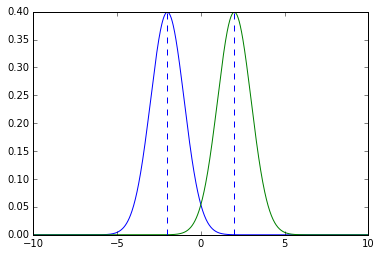

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import entropy
from scipy.stats import norm

x = np.linspace(-10, 10, 1000)

plt.plot(x, norm.pdf(x, -2, 1))
plt.plot(x, norm.pdf(x, 2, 1))
plt.axvline(-2, linestyle='--')
plt.axvline(2, linestyle='--')

plt.show()

И сравним два распределения с $\mu_1 = -2, \mu_2 = 2$, c $\sigma_1 = \sigma_2 = 5$.

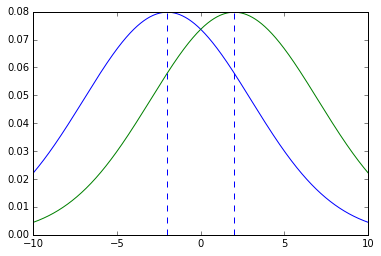

In [4]:
x = np.linspace(-10, 10, 1000)

plt.plot(x, norm.pdf(x, -2, 5))
plt.plot(x, norm.pdf(x, 2, 5))
plt.axvline(-2, linestyle='--')
plt.axvline(2, linestyle='--')

plt.show()

Чисто по евклидовой метрики растояние между ними одинаково, но на второй картинке распределения более похожие друг на друга чем на первой.

Это можно увидеть если вместо евклидовой метрики смотреть на растояние Кульбака-Лейблера между ними:

In [5]:
entropy(norm.pdf(x, -2, 5), norm.pdf(x, 2, 5)), entropy(norm.pdf(x, -2, 1), norm.pdf(x, 2, 1))

(0.24465034406492298, 7.9999999999999805)

По этой причине мы бы хотели научиться решать следующую задачу:

$$d \theta = \arg \max \mathcal{L}(X|\theta + d \theta), s.t. KL\left( p(x| \theta) || p(x| \theta + d \theta) \right) < \epsilon$$

Этим мы и займёмся.

### Генерация данных

Сгенерируем данные из распределения 2D-гауссианы с 5 параметрами: $\vec{\mu} = [2, -6]$, $\Sigma = \begin{pmatrix}
5 & 0.8\\
0.8 & 2
\end{pmatrix}$.

In [6]:
true_parameters = {
    'mean': np.array([2, -6]),
    'cov': np.array([[5, 0.8], 
                     [0.8, 2]])
}

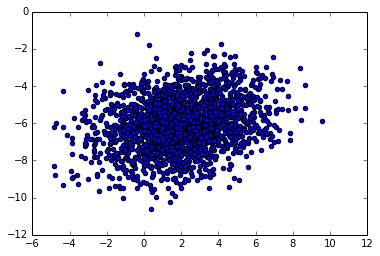

In [7]:
X_decart = np.random.multivariate_normal(**true_parameters, size=(2000,))
plt.scatter(X_decart[:, 0], X_decart[:, 1])

### Ввод функция для расчёта log-likelihood и pdf.

Первым делом, вспомним как выглядят плотность и log-likelihood для 2D-гаусса.


$$p(x|\mu, \Sigma) = \frac{1}{2 \pi |\Sigma|^{1/2}} \exp\left( - \frac{1}{2} (\vec{x} - \vec{\mu})^T \Sigma^{-1} (\vec{x} - \vec{\mu}) \right)$$

In [8]:
def norm_2d_pdf(x: np.ndarray, mean: np.ndarray, cov: np.ndarray):
    assert x.ndim == 1 and mean.ndim == 1
    assert len(x) == 2 and len(mean) == 2
    ll = np.exp(-(x - mean).dot(np.linalg.inv(cov).dot(x - mean)) / 2)
    ll *= 1 / (2 * np.pi * np.linalg.det(cov)**(0.5))
    return ll

assert np.abs(norm_2d_pdf(np.array([2., -6.]), **true_parameters) - 0.052021420545533555) < 1e-8
assert np.abs(norm_2d_pdf(np.array([1., -4.]), **true_parameters) - 0.013538015908347703) < 1e-8

In [9]:
def norm_2d_ll(x: np.ndarray, mean: np.ndarray, cov: np.ndarray):
    assert x.ndim == 1 and mean.ndim == 1
    assert len(x) == 2 and len(mean) == 2
    cov_inv = np.linalg.inv(cov)
    ll = -(x - mean).dot(cov_inv.dot(x - mean)) / 2
    ll -= (np.log(2 * np.pi) + np.log(np.linalg.det(cov)) / 2)
    return ll

assert np.abs(norm_2d_ll(np.array([-40., 33.3]), **true_parameters) + 745.0185997116541) < 1e-8

In [10]:
def norm_2d_ll_array(X, mean, cov):
    ll = 0
    for x in X:
        ll += norm_2d_ll(x, mean, cov)
    return ll

### Градиент 2D-нормального распределения

Мы хотим посчитать $\frac{\partial \log p(\vec{x}|\vec{\theta})}{\partial \vec{\theta}} $, где p это наша плотность вероятности, а $\theta$ - параметры распределения(среднее и матрица ковариации).

Подсказки:

$$\frac{\partial \log |X|}{\partial X} = |X|$$

$$\frac{\partial \log |X|}{\partial X} = |X|$$


<Здесь можно вызвать студента к доске, чтобы вспомнить азы дифференциирования по вектору>

In [12]:
def norm_2d_grad(x: np.ndarray, mean: np.ndarray, cov: np.ndarray):
    assert x.ndim == 1 and mean.ndim == 1
    assert len(x) == 2 and len(mean) == 2
    cov_inv = np.linalg.inv(cov)
    grad_mean = cov_inv.dot(x - mean)
    grad_cov = -(cov_inv - cov_inv.dot(np.outer(x - mean, x - mean)).dot(cov_inv)) / 2
    return grad_mean, grad_cov


assert True

### Расчёт матрицы Фишера

Флэшбек с прошлой лекции и семинара:

$$I_n = E\left[ \left( \frac{\partial p(\vec{x}|\vec{\theta})}{\partial \vec{\theta}} \right) 
\left( \frac{\partial p(\vec{x}|\vec{\theta})}{\partial \vec{\theta}}\right)^T  \right]$$

Производную мы посчитали выше. А как нам посчитать матожидание?

Усреднение по элементам выборки есть приближение среднего,поэтому самый простой способ это посчитать матрицу Фишера для каждого элемента нашей выборки и усреднить.

In [47]:
from typing import Callable, Union
def empirical_fisher(grad_func: Callable, X: np.ndarray, parameters: dict) -> Union[np.ndarray, np.ndarray]:
    """
    Функция принимает на вход матрицу X размера N x 2, функцию расчёта градиента
    для среднего и ковариации и параметры нормального распределения.
    
    На выход возвращается усреднённый по выборке градиент и матрица Фишнера.
    """
    N = len(X)
    grads = []
    for x in X:
        # Посчитать градиент для сэмпла
        grad_mean, grad_cov = grad_func(x, **parameters)
        # "Вытянуть" градиент в один вектор не забыв про условие симметричности матрицы ковариации
        grad = np.concatenate([grad_mean, grad_cov.ravel()[[0, 1, 3]]])
        grad[3] *= 2
        grads.append(grad)
    grads = np.vstack(grads)
    return grads.mean(axis=0), np.cov(grads.T)

In [48]:
def vec_to_covariance(vec):
    m = np.zeros((2, 2))
    m.ravel()[[0, 1, 3]] = vec
    m[1, 0] = m[0, 1]
    return m

### KL дивергенция

Мы будем сравнивать наши распределения по трём метрикам: log-likelihood, MSE по параметрам и KL-дивергенция.

$$KL\left(p(x|\theta)||p(x|\theta')\right) = \int p(x|\theta) \log \frac{p(x|\theta)}{p(x|\theta')} dx $$


In [49]:
def mse_difference(parameters_1, parameters_2):
    res = (((parameters_1['mean'] - parameters_2['mean'])**2).sum() + 
          ((parameters_1['cov'] - parameters_2['cov'])**2).sum())
    return res / (2 + 4)

def kl_difference(parameters_1, parameters_2):
    kl = 0
    kl += np.log( np.linalg.det(parameters_2['cov']) / np.linalg.det(parameters_1['cov']) )
    kl += np.trace( np.linalg.inv(parameters_2['cov']).dot(parameters_1['cov']) )
    kl += (parameters_2['mean'] - parameters_1['mean']).dot(
        np.linalg.inv(parameters_2['cov']).dot(parameters_2['mean'] - parameters_1['mean'])
    )
    kl -= 2
    kl /= 2
    return kl

### Связь KL-дивергенции и матрицы Фишера

Ещё раз запишем формулу:

$$KL\left(p(x|\theta)||p(x|\theta')\right) = \int p(x|\theta) \log \frac{p(x|\theta)}{p(x|\theta')} dx $$

Теперь возьмём первую производную по $\theta'$:


$$ 
\nabla_{\theta'} KL\left(p(x|\theta)||p(x|\theta')\right) = E\left[ \nabla_{\theta'} \log p(x|\theta')\right]
$$

In [50]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}
lr = 1e-2
sgd_mse = []
sgd_mse.append(mse_difference(true_parameters, parameters))

sgd_kl = []
sgd_kl.append(kl_difference(true_parameters, parameters))

sgd_mle = []
sgd_mle.append(norm_2d_ll_array(X_decart, **parameters))

for i in tqdm(range(100)):
    grad_mean_total = np.zeros(shape=2)
    grad_cov_total = np.zeros(shape=(2, 2))
    for x in X_decart:
        grad_mean, grad_cov = norm_2d_grad(x, **parameters)
        grad_mean_total += grad_mean / len(X_decart)
        grad_cov_total += grad_cov / len(X_decart)
        
    parameters['mean'] += lr * grad_mean_total
    parameters['cov'] += lr * grad_cov_total
    
    sgd_mse.append(mse_difference(true_parameters, parameters))
    sgd_kl.append(kl_difference(true_parameters, parameters))
    sgd_mle.append(norm_2d_ll_array(X_decart, **parameters))

    
print('mean', parameters['mean'], true_parameters['mean'])
print('cov', parameters['cov'], true_parameters['cov'])

100%|██████████| 100/100 [00:11<00:00,  8.75it/s]

mean [ 0.61737713 -1.94008779] [ 2 -6]
cov [[ 2.03105091 -0.46351413]
 [-0.46351413  3.2592346 ]] [[5.  0.8]
 [0.8 2. ]]


In [55]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}

lr = 1e-2
nat_grad_mse = []
nat_grad_mse.append(mse_difference(true_parameters, parameters))

nat_grad_kl = []
nat_grad_kl.append(kl_difference(true_parameters, parameters))

nat_grad_mle = []
nat_grad_mle.append(norm_2d_ll_array(X_decart, **parameters))

for i in tqdm(range(100)):
    grad_mean_total = np.zeros(shape=2)
    grad_cov_total = np.zeros(shape=(2, 2))
    grad, fisher = empirical_fisher(norm_2d_grad, X=X_decart, parameters=parameters)
    natural_grad = np.linalg.inv(fisher).dot(grad)
    # natural_grad = natural_grad / np.linalg.norm(natural_grad)
    
    parameters['mean'] += lr * natural_grad[:2]
    parameters['cov'] += lr * vec_to_covariance(natural_grad[2:])
    
    nat_grad_mse.append(mse_difference(true_parameters, parameters))
    nat_grad_kl.append(kl_difference(parameters, true_parameters))
    nat_grad_mle.append(norm_2d_ll_array(X_decart, **parameters))

    
print('mean', parameters['mean'], true_parameters['mean'])
print('cov', parameters['cov'], true_parameters['cov'])

100%|██████████| 100/100 [00:14<00:00,  6.86it/s]

mean [ 1.22923555 -4.45095969] [ 2 -6]
cov [[1.12806891 0.22390429]
 [0.22390429 0.41191225]] [[5.  0.8]
 [0.8 2. ]]


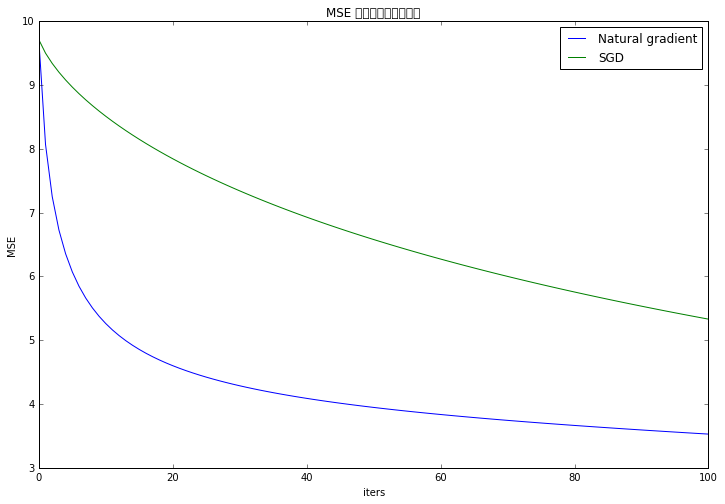

In [52]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_mse, label='Natural gradient')
plt.plot(sgd_mse, label='SGD')
plt.title('MSE сравнение')
plt.xlabel('iters')
plt.ylabel('MSE')
plt.legend()
plt.show()

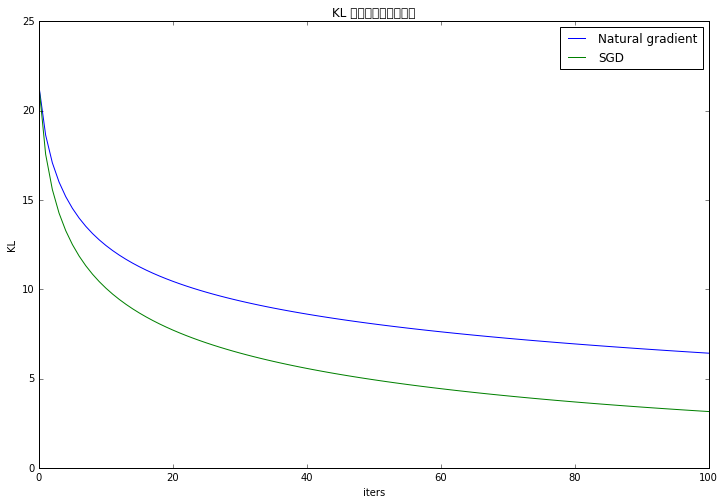

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_kl, label='Natural gradient')
plt.plot(sgd_kl, label='SGD')
plt.title('KL сравнение')
plt.xlabel('iters')
plt.ylabel('KL')
plt.legend()
plt.show()

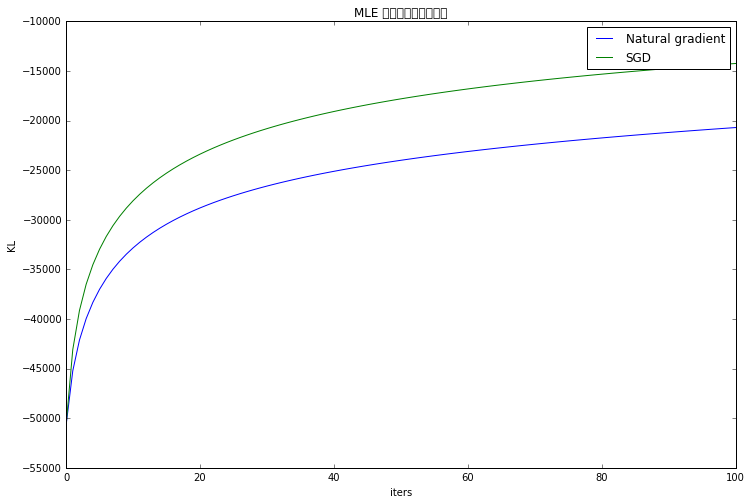

In [54]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_mle, label='Natural gradient')
plt.plot(sgd_mle, label='SGD')
plt.title('MLE сравнение')
plt.xlabel('iters')
plt.ylabel('KL')
plt.legend()
plt.show()

### Дополнительное задание

Выше мы считали матрицу Фишера эмпирическим путём. Это нормальный способ если выборка большая или если интегрировать по плотности распределения сложно, к примеру, если плотность распределения задаётся нейронной сетью.

Для нормального распределения матрицу Фишера не сложно посчитать аналитическим путём. 

Напишите свой код для аналитического расчёта матрицы Фишера в функции ниже(ничего кроме параметров распределения вам не понадобится).

Запустите код и скажите что изменилось?

In [22]:
def analytical_fisher(parameters: dict) -> Union[np.ndarray, np.ndarray]:
    """
    Функция принимает на вход матрицу X размера N x 2, функцию расчёта градиента
    для среднего и ковариации и параметры нормального распределения.
    
    На выход возвращается усреднённый по выборке градиент и матрица Фишнера.
    """
    N = len(X)
    grads = []
    for x in X:
        grad_mean, grad_cov = grad_func(x, **parameters)
        grad = np.concatenate([grad_mean, grad_cov.ravel()[[0, 1, 3]]])
        grads.append(grad)
    
    
    raise ValueError('Where is Fisher, dude?')
    
    return np.vstack(grads).mean(axis=0), 

In [23]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[1, 0.], 
                     [0., 1]])
}
lr = 1e-2
nat_grad_mse = []
nat_grad_mse.append(mse_difference(true_parameters, parameters))

nat_grad_kl = []
nat_grad_kl.append(kl_difference(true_parameters, parameters))

for i in tqdm(range(200)):
    grad_mean_total = np.zeros(shape=2)
    grad_cov_total = np.zeros(shape=(2, 2))
    grad, fisher = analytical_fisher(norm_2d_grad, X=X_decart, parameters=parameters)
    natural_grad = np.linalg.inv(fisher).dot(grad)
    
    parameters['mean'] += lr * natural_grad[:2]
    parameters['cov'] += lr * vec_to_covariance(natural_grad[2:])
    
    nat_grad_mse.append(mse_difference(true_parameters, parameters))
    nat_grad_kl.append(kl_difference(parameters, true_parameters))

NameError: name 'residual_between_parameters' is not defined

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(nat_grad_kl, label='Natural gradient')
plt.plot(sgd_kl, label='SGD')
plt.title('Comparison')
plt.xlabel('iters')
plt.ylabel('KL')
plt.legend()
plt.show()

## Wasserstain distance

Общая формула для расстояния Вассерштейна:

$$W_p(p, q) = \inf \int\limits_{\mathbb{R} \times \mathbb{R}} d(x, y)^p d \pi(x, y)$$



In [24]:
from scipy.stats import wasserstein_distance
from itertools import permutations
import numpy as np

In [25]:
def wasserstein_distance_brute_force(x, y):
    assert len(x) == len(y)
    min_distance = np.inf
    argmin_permutation = None
    for permutation in permutations(np.arange(len(x))):
        distance = np.mean(np.abs(x[np.array(permutation)] - y))
        if min_distance > distance:
            min_distance = distance
            argmin_permutation = permutation
    return min_distance


x = np.random.randn(4)
y = np.random.randn(4)
assert np.abs(wasserstein_distance_brute_force(x, y) - wasserstein_distance(x, y)) < 1e-8

In [26]:
def wasserstein_distance_smart_force(x, y):
    x_idx = np.argsort(x)
    x_idx_inverse = np.argsort(x_idx)
    y_idx = np.argsort(y)
    y_idx_inverse = np.argsort(y_idx)
    distance = np.mean(np.abs(x[x_idx] - y[y_idx]))
    return distance

wasserstein_distance_brute_force(x, y) == wasserstein_distance_smart_force(x, y)

True

In [32]:
N = 1000

x = np.random.randn(N) - 3
y = np.random.randn(N) + 3

In [41]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, push_notebook, show
from bokeh.models import CustomJS, Slider
from bokeh.layouts import row
from scipy.stats import gaussian_kde

output_notebook()

bw = 0.01

x_linspace = np.linspace(-10, 10, 1000)
density_x = gaussian_kde(x, bw_method=bw)
density_y = gaussian_kde(y, bw_method=bw)
fig = figure()
density_x_bokeh = fig.line(x_linspace, density_x(x_linspace), color="red")
density_y_bokeh = fig.line(x_linspace, density_y(x_linspace), color="blue")



def update_plot(n_moved):
    x_linspace = density_x_bokeh.data_source.data['x']
    
    x_idx = np.argsort(x)
    y_idx = np.argsort(y)
    
    x_copy = x.copy()
    print(n_moved)
    for i in range(n_moved):
        x_copy[x_idx[i]] = y[y_idx[i]]
    
    density_x = gaussian_kde(x_copy, bw_method=bw)
    density_x_bokeh.data_source.data['y'] = density_x(x_linspace)
    push_notebook(handle=bokeh_handle)  

Loading BokehJS ...

In [42]:
callback = CustomJS(code="""
if (IPython.notebook.kernel !== undefined) {
    var kernel = IPython.notebook.kernel;
    cmd = "update_plot(" + cb_obj.value + ")";
    kernel.execute(cmd, {}, {});
}
""")

slider = Slider(start=0, 
                end=len(x),
                value=0,
                step=1,
                title="Moved dots",
                callback=callback)
bokeh_handle = show(row(fig, slider), notebook_handle=True)